In [45]:
import numpy as np
import mne
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve
import matplotlib.pyplot as plt

## Data Loading

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/' 
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']

In [92]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = 1
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1
    return data, target

In [4]:
filepath = root + case + preictal_filenames[0]
preictal_data, preictal_target = load_EEG(filepath, 'preictal')

In [5]:
print(preictal_data.shape)
print(preictal_target)

(23, 230401)
1


In [6]:
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']
filepath = root + case + interictal_filenames[0]
interictal_data, interictal_target = load_EEG(filepath, 'interictal')

In [7]:
print(interictal_data.shape)
print(interictal_target)

(23, 921600)
-1


## Feature Extraction

In [8]:
seed = 42
N = 500
p = 2
m = 30
ar = ARMA(window_width=N, order=p, memory=m, seed=seed)

In [9]:
# extract features of preictal
preictal_times, preictal_AR, preictal_MA = ar.spin(sig=preictal_data, fs=256)

100%|██████████| 229899/229899 [00:02<00:00, 83443.61it/s] 


In [10]:
# extract features of interictal
interictal_times, interictal_AR, interictal_MA = ar.spin(sig=interictal_data, fs=256)

100%|██████████| 921098/921098 [00:09<00:00, 97208.69it/s] 


In [21]:
interictal_targets = np.ones(interictal_MA.shape[0])
preictal_targets = -1 * np.ones(preictal_MA.shape[0])

In [12]:
print(interictal_MA.shape, preictal_MA.shape)

(1842, 23, 2) (459, 23, 2)


## Model Training

In [22]:
X = np.concatenate((interictal_MA, preictal_MA), axis=0)
y = np.concatenate((interictal_targets, preictal_targets), axis=0)
print(X.shape)
print(y.shape)

(2301, 23, 2)
(2301,)


In [24]:
X[:,:,0].shape

(2301, 23)

In [25]:
X_1 = X[:,:,0] # ARMA coeff 1
X_2 = X[:,:,1] # ARMA coeff 2

In [46]:
model_X1 = LogisticRegression(random_state=0)
model_X1.fit(X_1, y)

LogisticRegression(random_state=0)

In [47]:
model_X2 = LogisticRegression(random_state=0)
model_X2.fit(X_2, y)

LogisticRegression(random_state=0)

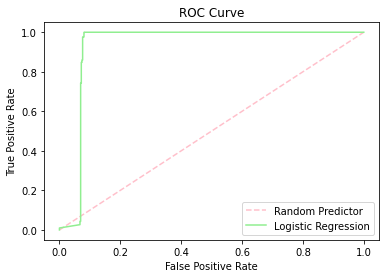

In [49]:
lr_probs = model_X1.predict_proba(X_1)
lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(X_1))]

ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

plt.figure()
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='pink', label='Random Predictor')
plt.plot(lr_fpr, lr_tpr, color='lightgreen', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

(2301, 23) (2301, 2)


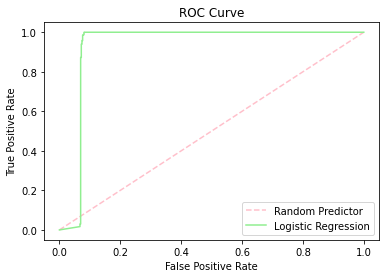

In [65]:
lr_probs = model_X2.predict_proba(X_2)
print(X_2.shape, lr_probs.shape)
lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(X_2))]

ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

plt.figure()
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='pink', label='Random Predictor')
plt.plot(lr_fpr, lr_tpr, color='lightgreen', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Model Testing

In [56]:
filepath = root + case + preictal_filenames[1]
preictal_data, preictal_target = load_EEG(filepath, 'preictal')
print(preictal_data.shape, preictal_target)

filepath = root + case + interictal_filenames[1]
interictal_data, interictal_target = load_EEG(filepath, 'interictal')
print(interictal_data.shape, interictal_target)

X = np.concatenate((interictal_data, preictal_data), axis=1)
print(X.shape)

(23, 230401) 1
(23, 921600) -1
(23, 1152001)


In [79]:
# online prediction
fs = 256   # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter

print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

np.random.seed(42)
n_samples = X.shape[1]                  # Length of input signal
e = X                                   # Feed input signal
a = 1.8 * np.random.randn(n_c, n_i)       # Initialise AR coefficients
c = m*np.ones(m)                          # Initialise MA coefficients
c = c/c.sum()

k = np.zeros(1)
Ik = N                                    # Set window width
ar_index_list = []                        # Sequential buffer of time index
ar_hats_list = []                         # Sequential buffer of AR coefficients (conisder replacing these with vstack)
a_ma_list = []
model_1_proba_list = []
model_2_proba_list = []
mean_pred_list = []
for t in range(Ik + n_i, n_samples):      # Moving window starting from index 1 to (n_samples-1)
    if (t % N == 0):                      # Decimation policy: a is computed once every N samples
        window_start = t - Ik - n_i + 1
        window_end = t 
        a_hat = np.zeros((n_c, n_i))
        phi = np.zeros((n_c, n_i))
        for i in range(n_c):                          # Iterate electrodes
            x_t = e[i, window_start:window_end]       # Multi-channel window over input signal
            N_window = len(x_t)
            ymat = np.zeros((N_window-n_i, n_i))
            yb = np.zeros((N_window-n_i, n_i))
            
            for _c in range(n_i, 0, -1):
                ymat[:, n_i-_c] = x_t[n_i-_c:-_c]
            
            yb = x_t[n_i:]
            a_hat[i] = np.linalg.pinv(ymat) @ yb
        
        a_ma = np.zeros((n_c, n_i))
        ar_hats_k = len(ar_hats_list)-1               # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for j in range(m):                            # MA smoothing of AR parameters going back m units of time, in timescale k (+1 ensures it goes up to m)
            if len(ar_hats_list) > m:                 # Only begin smoothing once unit of time passed is greater than m (MA lookback parameter) 
                a_ma = c[j] * ar_hats_list[ar_hats_k-j]
        
        a1 = a_ma[:,0]
        a2 = a_ma[:,1]
        pred_a1 = model_X1.predict_proba(a1.reshape(1,-1))[:,1]
        pred_a2 = model_X2.predict_proba(a2.reshape(1,-1))[:,1]
        pred_mean = np.mean(np.concatenate((pred_a1, pred_a2), axis=0), axis=0)
        model_1_proba_list.append(pred_a1)
        model_2_proba_list.append(pred_a2)
        mean_pred_list.append(pred_mean)
        
        ar_index_list.append(t)                       # Record time index of when a is computed
        ar_hats_list.append(a_hat)
        a_ma_list.append(a_ma)
                        
ar_index = np.array(ar_index_list)
ar_hats = np.array(ar_hats_list)
ars = np.array(a_ma_list)
print('Input dimension:', e.shape)
print('Output dimension:', ar_hats.shape)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz
Input dimension: (23, 1152001)
Output dimension: (2249, 23, 2)


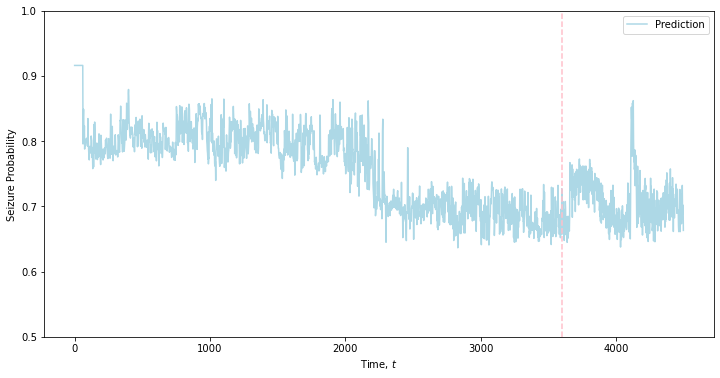

In [93]:
t = np.arange(0, 2249) / (256/512)
plt.figure(figsize=(12,6))
# plt.plot(t, model_1_proba_list, label='Model 1')
# plt.plot(t, model_2_proba_list, label='Model 2')
plt.plot(t, mean_pred_list, label='Prediction', color='lightblue')
plt.axvline(x=3600, ls='--', color='pink')
# plt.plot(t, np.mean(np.array([model_1_proba_list, model_2_proba_list]), axis=0), label='Mean')
plt.ylim([0.5,1])
plt.xlabel('Time, $t$')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()